### <font color="red">Part 1: Data Preparation, Descriptive, Exploratory Analysis </font>

 <font color="red"> Imports </font>

In [2]:
import pandas as pd
import glob
import warnings
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta
from collections import Counter
from nltk.probability import FreqDist
import seaborn as sns

warnings.filterwarnings("ignore")

 <font color="red"> Data Preparation </font>

In [3]:
#data downloaded from https://s3.amazonaws.com/capitalbikeshare-data/index.html
#List of files that we want to merge
all_files = glob.glob("../dc/*tripdata.csv")

print('Number of files: ' + str(len(all_files)))
#read all files
list_of_dataframe = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_of_dataframe.append(df)
    
#Make sure all the dataframe have the same columns
# for i in range(len(list_of_dataframe)):
#    print(list_of_dataframe[i].columns)

Number of files: 26


In [4]:
#Merge all the files
merged_data = pd.concat(list_of_dataframe, axis=0, ignore_index=True)
#Cast the "Start date' to datetime data type
merged_data["Start date"]=pd.to_datetime(merged_data["Start date"])
#Sort the data based on "Start date"
merged_data=merged_data.sort_values("Start date")
merged_data.head()

,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,552,2018-01-01 00:05:06,2018-01-01 00:14:18,31104,Adams Mill & Columbia Rd NW,31400,Georgia & New Hampshire Ave NW,W00886,Member
1,1282,2018-01-01 00:14:30,2018-01-01 00:35:53,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,W01435,Casual
2,1265,2018-01-01 00:14:53,2018-01-01 00:35:58,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,W21242,Casual
3,578,2018-01-01 00:15:31,2018-01-01 00:25:09,31406,14th & Upshur St NW,31103,16th & Harvard St NW,W21322,Casual
4,372,2018-01-01 00:18:02,2018-01-01 00:24:15,31618,4th & East Capitol St NE,31619,Lincoln Park / 13th & East Capitol St NE,W00119,Member


In [5]:
#Select only the important attributes
merged_data=merged_data[['Duration','Start date','End date','Start station number','Member type']]
#Write the data to csv file
merged_data.to_csv('../dc/merged_data.csv',index=False)

<font color="red"> Descriptive Analysis, EDA </font>


In [6]:
data =pd.read_csv('../dc/merged_data.csv')
print(data.shape)
print('Unique stations: '+str(data['Start station number'].nunique()))
count=pd.DataFrame(data['Start station number'].value_counts().nlargest(10))
count=count.reset_index()
count.columns
count.columns=['Start station number','Total_trip']
count_type=pd.DataFrame(data.groupby(['Start station number','Member type'])['Start station number'].count().rename('count_by_membership'))
count_type=count_type.reset_index()
count_type.head()

(7315971, 5)
Unique stations: 583


,Start station number,Member type,count_by_membership
0,0,Casual,34
1,0,Member,742
2,31000,Casual,1199
3,31000,Member,2951
4,31001,Casual,860


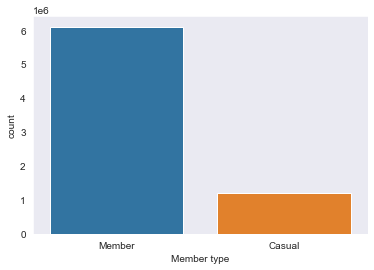

In [7]:
#Casual Member ratio
# plot and save with seaborn
sns.set_style("dark")
countplot = sns.countplot(x="Member type", data=data);

fig = countplot.get_figure()
fig.savefig('../figures/compare_member_type_full_data.png')

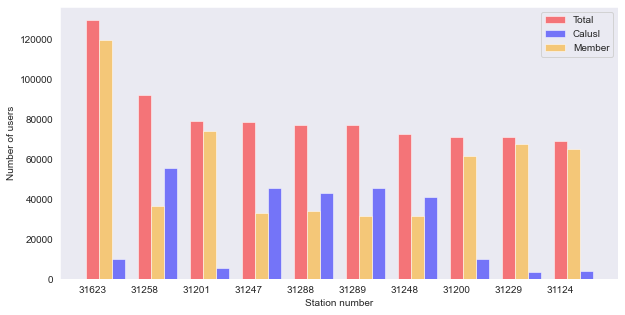

In [8]:
#Total member, casual, registered members per first 10 prominent stations
barWidth = 0.25
cleaned_data=count
casual=count_type[count_type['Member type']=='Casual']
member=count_type[count_type['Member type']=='Member']

d=count.merge(casual, on='Start station number', how='inner', indicator=True)
d=d[['Start station number','Total_trip','count_by_membership']]
d=d.merge(member, on='Start station number', how='inner', indicator=True)
d=d[['Start station number', 'Total_trip', 'count_by_membership_x','count_by_membership_y']]

pos = list(range(len(d))) 
width = 0.25 
labels=d['Start station number']
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(pos, 
        d['Total_trip'], 
        width, 
        alpha=0.5, 
        color='red', 
        label='Total') 

plt.bar([p + width*2 for p in pos], 
        d['count_by_membership_x'], 
        width, 
        alpha=0.5, 
        color='blue',
        label='Calusl')

plt.bar([p + width for p in pos], 
        d['count_by_membership_y'],
        width, 
        alpha=0.5, 
        color='orange',
        label="Member")

plt.xticks(range(len(labels)), labels)
plt.legend()
plt.xlabel('Station number')
plt.ylabel("Number of users")
plt.show()

plt.savefig('../figures/compare_member_type_full_data_stations.png')

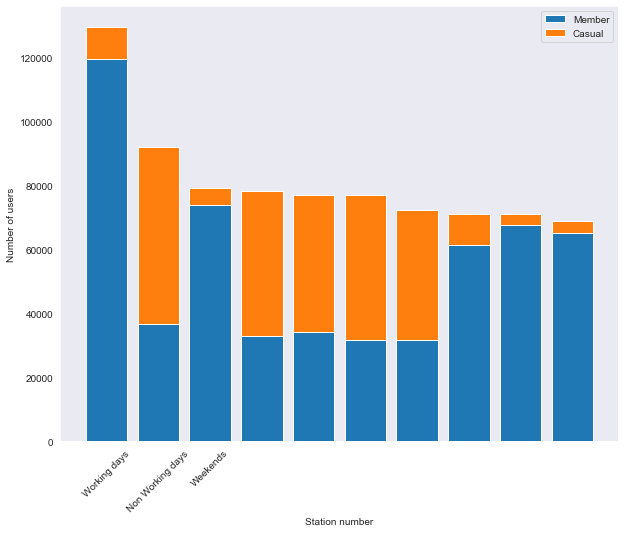

<Figure size 432x288 with 0 Axes>

In [28]:
#Registered, casual members comparision
data1 = d['count_by_membership_x']
data2 = d['count_by_membership_y']
fig, ax = plt.subplots(figsize=(10,8))
plt.xticks(rotation=45)
plt.bar(range(len(data2)), data2,label="Member")
plt.bar(range(len(data1)), data1, bottom=data2,label="Casual")
plt.legend()
plt.xticks(range(len(labels)), labels)
plt.xlabel('Station number')
plt.ylabel("Number of users")
plt.show()
plt.savefig('../figures/compare_member_type_rides_stacked_bar_charts.png')

### <font color="red">Select only the prominant station </font>


In [18]:

data_station_31623=data[data['Start station number']==31623] ##this is the data that we are going to use for EDA

print('Total rides with 31623 station (Columbus Circle / Union Station) ' + str(data_station_31623.shape[0]))
data_station_31623=data_station_31623[["Start date","Member type"]]

data_station_31623["Start date"]=pd.to_datetime(data_station_31623["Start date"],format='%Y-%m-%d %H:%M:%S')
data_station_31623['hour of day']=data_station_31623["Start date"].dt.hour
data_station_31623['day of the month']=data_station_31623["Start date"].dt.day

data_station_31623['date']=data_station_31623["Start date"].dt.date
count=pd.DataFrame(data_station_31623.groupby(['date','hour of day','Member type'])\
                   ['hour of day'].count().rename('number of users'))


count=count.reset_index()

casual_hourly=count[count['Member type']=="Casual"][['date','hour of day','number of users']]
member_hourly=count[count['Member type']=="Member"][['date','hour of day','number of users']]

member_hourly=member_hourly.reset_index().drop('index',axis=1)

member_hourly['date_time']=None
for i in range(len(member_hourly)):
    member_hourly['date_time'][i]=timedelta(hours=int(member_hourly['hour of day'].iloc[i]))+pd.to_datetime(member_hourly['date'].iloc[i])
    
member_hourly=member_hourly[['date_time',"number of users"]]

casual_hourly=casual_hourly.reset_index().drop('index',axis=1)

casual_hourly.index

casual_hourly['date_time']=None
for i in range(len(casual_hourly)):
    casual_hourly['date_time'][i]=timedelta(hours=int(casual_hourly['hour of day'].iloc[i]))+pd.to_datetime(casual_hourly['date'].iloc[i])
    
casual_hourly=casual_hourly[['date_time','number of users']]

print(casual_hourly.shape)
casual_hourly.to_csv('../dc/casual_hourly.csv',index=False)

print(member_hourly.shape)
member_hourly.to_csv('../dc/member_hourly.csv',index=False)

count_by_date=pd.DataFrame(data_station_31623.groupby(['date','Member type'])['hour of day'].count().rename('number of users'))
count_by_date.head()

count_by_date=count_by_date.reset_index()

casual_daily=count_by_date[count_by_date['Member type']=="Casual"][['date','number of users']]
member_daily=count_by_date[count_by_date['Member type']=="Member"][['date','number of users']]

casual_daily.to_csv('../dc/casual_daily.csv',index=False)
member_daily.to_csv('../dc/member_daily.csv',index=False)

#print('Total rides: '+str(member_hourly.shape[0]+ casual_hourly.shape[0]))

Total rides with 31623 station (Columbus Circle / Union Station) 129514
(4614, 2)
(13842, 2)
Total rides: 18456


In [13]:
#Check with holiday, type of week day

#Note that in Python Monday is 0 unlike Javascript style where Sunday is 0
sel_station =data[data['Start station number']==31623] ##this is the data that we are going to use for EDA
sel_station["Start date"]=pd.to_datetime(data["Start date"],format='%Y-%m-%d %H:%M:%S')

sel_station['day of week']=sel_station["Start date"].dt.weekday

#install with pip install holidays
import holidays

holiday_dates_list=[]
#Print all the holidays in US in year 2018, 2019
for ptr in holidays.US(years = 2018).items():
    holiday_dates_list.append(ptr[0])
for ptr in holidays.US(years = 2019).items():
    holiday_dates_list.append(ptr[0]) 
for ptr in holidays.US(years = 2020).items():
    holiday_dates_list.append(ptr[0]) 
us_holidays=tuple(holiday_dates_list)
print(us_holidays)


sel_station['is holiday'] = sel_station['Start date'].apply(lambda x: 1 if x in us_holidays else 0)

print(sel_station['is holiday'].value_counts()) # 127914 1600 ;  2018 jan to 2020 feb



(datetime.date(2018, 1, 1), datetime.date(2018, 1, 15), datetime.date(2018, 2, 19), datetime.date(2018, 5, 28), datetime.date(2018, 7, 4), datetime.date(2018, 9, 3), datetime.date(2018, 10, 8), datetime.date(2018, 11, 11), datetime.date(2018, 11, 12), datetime.date(2018, 11, 22), datetime.date(2018, 12, 25), datetime.date(2019, 1, 1), datetime.date(2019, 1, 21), datetime.date(2019, 2, 18), datetime.date(2019, 5, 27), datetime.date(2019, 7, 4), datetime.date(2019, 9, 2), datetime.date(2019, 10, 14), datetime.date(2019, 11, 11), datetime.date(2019, 11, 28), datetime.date(2019, 12, 25), datetime.date(2020, 1, 1), datetime.date(2020, 1, 20), datetime.date(2020, 2, 17), datetime.date(2020, 5, 25), datetime.date(2020, 7, 4), datetime.date(2020, 7, 3), datetime.date(2020, 9, 7), datetime.date(2020, 10, 12), datetime.date(2020, 11, 11), datetime.date(2020, 11, 26), datetime.date(2020, 12, 25))
0    127914
1      1600
Name: is holiday, dtype: int64


max:  84415
min:  60
count:  129514
median:  537.0
744.3511048998564
std:  1506.2761488970432
var:  2268867.8367361072


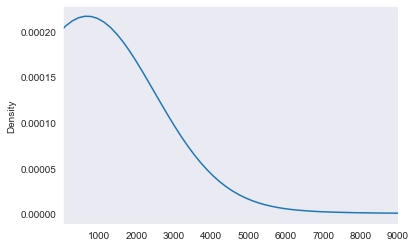

In [16]:
#Duration related analysis
sel_station['date']=sel_station["Start date"].dt.date

max = sel_station['Duration'].max()
print("max: ", max)
min = sel_station['Duration'].min()
print("min: ", min)
count = sel_station['Duration'].count()
print("count: ", count)
median = sel_station['Duration'].median() 
print("median: ", median)
mean = sel_station['Duration'].mean()
print(mean)
std = sel_station['Duration'].std() 
print("std: ", std)
var = sel_station['Duration'].var() 
print("var: ", var)

series = pd.Series(df['Duration'])
ax.set_xlabel("durations in Sec (practically between 30-9000)")
ax.set_ylabel("duratoin PDF")
ax = series.plot.kde(bw_method=1)
ax.set_xlim(30, 9000)
fig = ax.get_figure()
fig.savefig("../figures/PDF.png")


Considering duration more than 3600 an anomaly (normally rides are < 1800 secs) 
Anomaly ratio: 
Registered Member - 0.004626453609972392
Casual Member - 0.1287059294871795
Casual Member anomaly duration is 27.98 times more than Registered member


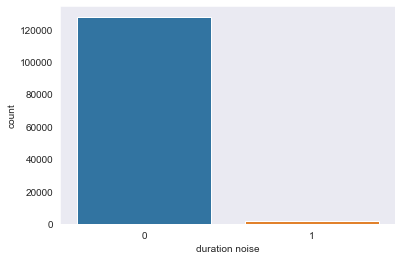

In [20]:


#consider duration more than 3600 an anomaly (normally rides are < 1800 secs)
max_dur=3600

sel_station['duration noise'] = sel_station['Duration'].apply(lambda x: 1 if int(x)>max_dur else 0)
casual_=sel_station[sel_station['Member type']=='Casual'];
member_=sel_station[sel_station['Member type']=='Member'];
print('Considering duration more than 3600 an anomaly (normally rides are < 1800 secs) ')
#print(casual_.shape)
#print(member_.shape)
#print(casual_[casual_['Duration']>max_dur].shape)
#print(member_[member_['Duration']>max_dur].shape)

print('Anomaly ratio: \nRegistered Member - '+str(member_[member_['Duration']>max_dur].shape[0]/member_.shape[0])
     +'\nCasual Member - '+str(casual_[casual_['Duration']>max_dur].shape[0]/casual_.shape[0]))

print('Casual Member anomaly duration is '+ str(round(round(casual_[casual_['Duration']>max_dur].shape[0]/casual_.shape[0], 4)/ round(member_[member_['Duration']>max_dur].shape[0]/member_.shape[0], 4), 2)) +' times more than Registered member')
# plot and save with seaborn
sns.set_style("dark")
countplot_all = sns.countplot(x="duration noise", data=sel_station);
fig_all = countplot_all.get_figure()
fig_all.savefig('../figures/durations_segregation.png')




Mean duration seconds on working days: 605.62
Mean duration seconds on non-working days: 776.4
Mean duration seconds on weekends: 782.85


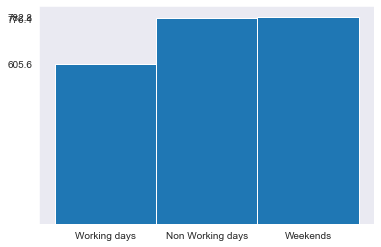

In [26]:
#Explore working days (weekdays excluding holidays) and non-working days (the negation) and duration
sel_station.head()

workingday=sel_station[(sel_station['day of week'] <5) & (sel_station['is holiday']==0) & (sel_station['duration noise']==0)]
#(104939, 9)
print('Mean duration seconds on working days: ' + str(round(workingday['Duration'].mean(),2))) ##sum: 63426804 604.4159368776146

nonworkingday=sel_station[((sel_station['day of week'] >=5) | (sel_station['is holiday']==1) ) & (sel_station['duration noise']==0)]
print('Mean duration seconds on non-working days: ' + str(round(nonworkingday['Duration'].mean(),2))) 

weekends=sel_station[(sel_station['day of week'] >=5) & (sel_station['duration noise']==0)]
print('Mean duration seconds on weekends: ' + str(round(weekends['Duration'].mean(),2))) #1063.3015772870663

holidays=sel_station[(sel_station['is holiday']==1) & (sel_station['duration noise']==0)]
#print(holidays['Duration'].mean()) #1063.3015772870663

top=[('Working days',workingday['Duration'].mean()),('Non Working days',nonworkingday['Duration'].mean()),('Weekends',weekends['Duration'].mean())]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)

plt.savefig('../figures/type_of_day_duration_3600_sec.png')




688.06
1084.95
1101.23


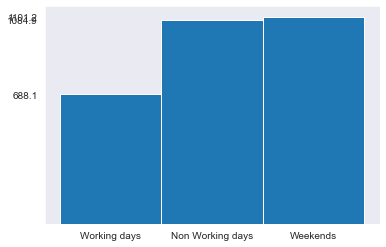

In [27]:
workingday_all=sel_station[(sel_station['day of week'] <5) & (sel_station['is holiday']==0)]
nonworkingday_all=sel_station[(sel_station['day of week'] >=5) | (sel_station['is holiday']==1)]
weekends_all=sel_station[(sel_station['day of week'] >=5)]
holidays_all=sel_station[(sel_station['is holiday']==1)]
print('\n')
print(round(workingday_all['Duration'].mean(),2)) #1063.3015772870663
print(round(nonworkingday_all['Duration'].mean(),2)) #1063.3015772870663
print(round(weekends_all['Duration'].mean(), 2)) #1063.3015772870663
#print(round(holidays_all['Duration'].mean(),2)) #1063.3015772870663

top=[('Working days',workingday_all['Duration'].mean()),('Non Working days',nonworkingday_all['Duration'].mean()),('Weekends',weekends_all['Duration'].mean())]

labels, ys = zip(*top)
xs = np.arange(len(labels)) 
width = 1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)

plt.savefig('../figures/type_of_day_duration_all.png')

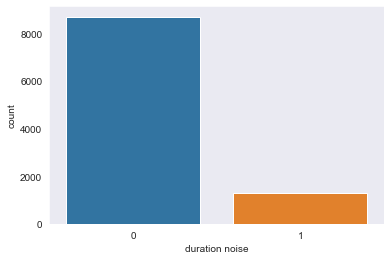

In [87]:
countplot_casual= sns.countplot(x="duration noise", data=casual_);
fig_casual = countplot_casual.get_figure()
fig_casual.savefig('../figures/durations_segregation_casual.png')



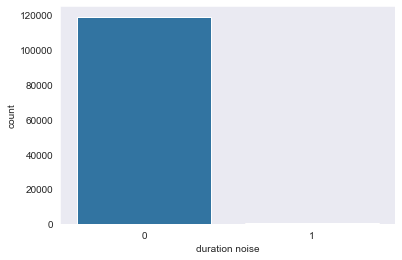

In [88]:
countplot_mem = sns.countplot(x="duration noise", data=member_);
fig_mem= countplot_mem.get_figure()
fig_mem.savefig('../figures/durations_segregation_member.png')


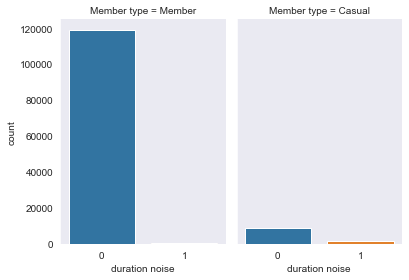

In [90]:
g = sns.catplot(x="duration noise", col="Member type",
                data=sel_station, kind="count",
                height=4, aspect=.7);

g.savefig('../figures/cat_durations_segregation.png')